### Import Packages

In [1]:
# Import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import shape
import seaborn as sns
from datetime import datetime
import os
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Read file and data preprocess

In [2]:
regression_model_input_O = pd.read_csv('Data/Gainesville/GNV_regression_model_input_O_new.csv')
regression_model_input_O.head()

,cluster,Start_lat,Start_lng,ridership,geometry,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,...,pct_terrain,pct_sky,pct_person,pct_rider,pct_car,pct_truck,pct_bus,pct_train,pct_motorcycle,pct_bicycle
0,0,29.651089,-82.324999,5716,POINT (-82.32499856177155 29.65108915928516),0.0,2.0,0.0,2.0,16.0,...,0.094971,0.149075,0.007569,0.00000,0.001864,0.036924,0.058686,0.014393,0.000000,0.000000
1,1,29.650193,-82.352017,5330,POINT (-82.35201655767153 29.650193460381775),1.0,0.0,1.0,0.0,0.0,...,0.061321,0.301616,0.000424,0.00000,0.004898,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,29.623447,-82.376004,4089,POINT (-82.3760035753828 29.62344653239105),3.0,0.0,0.0,0.0,0.0,...,0.076261,0.240125,0.000295,0.00139,0.021238,0.000000,0.000000,0.000000,0.003128,0.021902
3,3,29.641975,-82.340969,4044,POINT (-82.34096941199606 29.641975006637164),0.0,0.0,1.0,0.0,1.0,...,0.000000,0.094209,0.002452,0.00000,0.007189,0.000002,0.000000,0.000000,0.000000,0.000000
4,4,29.655959,-82.302074,3702,POINT (-82.30207376984127 29.655958804232803),0.0,0.0,0.0,0.0,0.0,...,0.117449,0.135673,0.006008,0.00000,0.003923,0.000000,0.000000,0.000000,0.000000,0.000000


In [3]:
regression_model_input_O.columns

Index(['cluster', 'Start_lat', 'Start_lng', 'ridership', 'geometry',
       'other_num_buff250', 'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'GEOID', 'MED_AGE', 'AVE_HH_SZ',
       'HS_PER_AC', 'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity',
       'Den_Bike_Lane', 'Den_Transit_Route', 'Den_Road_Network', 'school',
       'bar', 'fast_food', 'restaurant', 'bank', 'parking', 'cafe', 'fountain',
       'pub', 'theatre', 'library', 'shelter', 'place_of_worship', 'clinic',
       'bus_station', 'bicycle_parking', 'hospital', 'bicycle_repair_station',
       'pct_road', 'pct_sidewalk', 'pct_building', 'pct_wall', 'pct_fence',
       'pct_pole', 'pct_traffic_light', 'pct_traffic_sign', 'pct_vegetation',
       'pct_terr

### Data Ready for regression models

#### remove some variables and rename some variables

In [4]:
# O_clusters
regression_model_input_O_final = regression_model_input_O.copy()
regression_model_input_O_final = regression_model_input_O_final.drop(columns = {'cluster', 'geometry', 'GEOID'})
regression_model_input_O_final['ridership'] = regression_model_input_O_final['ridership']/933 # rides per day
regression_model_input_O_final['PCT_WHITE'] = regression_model_input_O_final['PCT_WHITE']/100 # PCT_WHITE
POI_list = ['school', 'bar', 'fast_food', 'restaurant', 'bank', 'parking', 'cafe', 'fountain', 'pub', 'theatre',
       'library', 'shelter', 'clinic', 'bus_station', 'bicycle_parking', 'hospital', 'bicycle_repair_station', 'place_of_worship']
dist_POI_list = ['dist_from_school', 'dist_from_bar', 'dist_from_fast_food', 'dist_from_restaurant', 'dist_from_bank', 
                 'dist_from_parking', 'dist_from_cafe', 'dist_from_fountain', 'dist_from_pub', 'dist_from_theatre',
                 'dist_from_library', 'dist_from_shelter', 'dist_from_clinic', 'dist_from_bus_station', 
                 'dist_from_bicycle_parking', 'dist_from_hospital', 'dist_from_bicycle_repair_station', 'dist_from_place_of_worship']
for i in range (len(POI_list)):
    regression_model_input_O_final = regression_model_input_O_final.rename(columns = {POI_list[i]:dist_POI_list[i]})
    regression_model_input_O_final[dist_POI_list[i]] = regression_model_input_O_final[dist_POI_list[i]]/1600
pct_list = ['pct_road', 'pct_sidewalk', 'pct_building', 'pct_wall', 'pct_fence', 'pct_pole', 'pct_traffic_light', 
            'pct_traffic_sign', 'pct_vegetation', 'pct_terrain', 'pct_sky', 'pct_person', 'pct_rider', 'pct_car',
            'pct_truck', 'pct_bus', 'pct_train', 'pct_motorcycle', 'pct_bicycle']
SVI_pct_list = ['SVI_pct_road', 'SVI_pct_sidewalk', 'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole', 
                'SVI_pct_traffic_light', 'SVI_pct_traffic_sign', 'SVI_pct_vegetation', 'SVI_pct_terrain', 'SVI_pct_sky', 
                'SVI_pct_person', 'SVI_pct_rider', 'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_train', 
                'SVI_pct_motorcycle', 'SVI_pct_bicycle']
for i in range (len(pct_list)):
    regression_model_input_O_final = regression_model_input_O_final.rename(columns = {pct_list[i]:SVI_pct_list[i]})
regression_model_input_O_final.head()

,Start_lat,Start_lng,ridership,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,...,SVI_pct_terrain,SVI_pct_sky,SVI_pct_person,SVI_pct_rider,SVI_pct_car,SVI_pct_truck,SVI_pct_bus,SVI_pct_train,SVI_pct_motorcycle,SVI_pct_bicycle
0,29.651089,-82.324999,6.126474,0.0,2.0,0.0,2.0,16.0,1.0,134.0,...,0.094971,0.149075,0.007569,0.00000,0.001864,0.036924,0.058686,0.014393,0.000000,0.000000
1,29.650193,-82.352017,5.712755,1.0,0.0,1.0,0.0,0.0,0.0,42.0,...,0.061321,0.301616,0.000424,0.00000,0.004898,0.000000,0.000000,0.000000,0.000000,0.000000
2,29.623447,-82.376004,4.382637,3.0,0.0,0.0,0.0,0.0,0.0,11.0,...,0.076261,0.240125,0.000295,0.00139,0.021238,0.000000,0.000000,0.000000,0.003128,0.021902
3,29.641975,-82.340969,4.334405,0.0,0.0,1.0,0.0,1.0,1.0,13.0,...,0.000000,0.094209,0.002452,0.00000,0.007189,0.000002,0.000000,0.000000,0.000000,0.000000
4,29.655959,-82.302074,3.967846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.117449,0.135673,0.006008,0.00000,0.003923,0.000000,0.000000,0.000000,0.000000,0.000000


#### Show columns

In [5]:
regression_model_input_O_final.columns

Index(['Start_lat', 'Start_lng', 'ridership', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'MED_AGE', 'AVE_HH_SZ', 'HS_PER_AC',
       'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network', 'dist_from_school',
       'dist_from_bar', 'dist_from_fast_food', 'dist_from_restaurant',
       'dist_from_bank', 'dist_from_parking', 'dist_from_cafe',
       'dist_from_fountain', 'dist_from_pub', 'dist_from_theatre',
       'dist_from_library', 'dist_from_shelter', 'dist_from_place_of_worship',
       'dist_from_clinic', 'dist_from_bus_station',
       'dist_from_bicycle_parking', 'dist_from_hospital',
       'dist_from_bicycle_repair_stat

#### descriptive statistics

#### O_cluster

In [6]:
# ridership
regression_model_input_O_final['ridership'].describe()

count    599.000000
mean       0.304063
std        0.608932
min        0.001072
25%        0.049303
50%        0.107181
75%        0.263666
max        6.126474
Name: ridership, dtype: float64

In [7]:
# No. of POI within a 250-m cluster buffer
regression_model_input_O_final[['other_num_buff250', 'residential_num_buff250',
       'education_num_buff250', 'cultural_num_buff250',
       'recreational_num_buff250', 'social_num_buff250',
       'transportation_num_buff250', 'commercial_num_buff250',
       'government_num_buff250', 'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250']].describe()

,other_num_buff250,residential_num_buff250,education_num_buff250,cultural_num_buff250,recreational_num_buff250,social_num_buff250,transportation_num_buff250,commercial_num_buff250,government_num_buff250,religion_num_buff250,health_num_buff250,publicsafety_num_buff250
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,0.138564,0.497496,0.520868,0.151920,2.056761,0.590985,13.676127,2.235392,0.048414,0.460768,0.190317,0.055092
std,0.553945,0.984619,0.775340,0.515926,7.085015,1.522842,23.644566,4.272845,0.287987,0.952753,0.623272,0.228350
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,16.000000,2.500000,0.000000,1.000000,0.000000,0.000000
max,5.000000,10.000000,4.000000,4.000000,77.000000,14.000000,134.000000,21.000000,3.000000,7.000000,5.000000,1.000000


In [8]:
# census tract socio-demographics & built environment
regression_model_input_O_final[['MED_AGE', 'AVE_HH_SZ', 'HS_PER_AC',
       'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network']].describe()

,MED_AGE,AVE_HH_SZ,HS_PER_AC,PCT_WHITE,DEN_POP,PCT_MALE,LU_diversity,Den_Bike_Lane,Den_Transit_Route,Den_Road_Network
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,29.373623,2.171252,4.301653,0.541277,9.598180,0.484958,1.189413,0.038138,0.604880,0.063967
std,8.034947,0.418322,5.460080,0.233603,11.196242,0.055159,0.451722,0.073395,0.950984,0.086273
min,19.900000,1.500000,0.020000,0.046300,0.030000,0.297886,-0.000000,0.000000,0.000000,0.002301
25%,22.600000,1.890000,1.305000,0.413400,3.425000,0.454545,0.865870,0.007443,0.114237,0.015257
50%,28.500000,2.160000,2.330000,0.596600,5.420000,0.487093,1.275987,0.019441,0.371255,0.034900
75%,35.100000,2.490000,4.695000,0.746600,12.560000,0.515152,1.491962,0.038844,0.778280,0.067304
max,69.100000,3.340000,30.720000,0.871200,63.250000,0.685050,1.989428,0.532501,7.609585,0.538240


In [9]:
# Distance to POI
regression_model_input_O_final[dist_POI_list].describe()

,dist_from_school,dist_from_bar,dist_from_fast_food,dist_from_restaurant,dist_from_bank,dist_from_parking,dist_from_cafe,dist_from_fountain,dist_from_pub,dist_from_theatre,dist_from_library,dist_from_shelter,dist_from_clinic,dist_from_bus_station,dist_from_bicycle_parking,dist_from_hospital,dist_from_bicycle_repair_station,dist_from_place_of_worship
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,0.538942,1.497527,0.545755,0.468549,0.778009,0.287263,0.790881,0.507216,1.318244,1.220050,0.915060,0.354797,0.960452,2.603371,0.357652,1.435733,1.342796,0.379984
std,0.384362,1.052909,0.471749,0.392070,0.568654,0.280002,0.571783,0.342142,0.982033,0.921983,0.706324,0.288910,0.625279,1.267021,0.308833,1.060027,1.050166,0.291169
min,0.000000,0.043073,0.009403,0.012109,0.025011,0.000000,0.019351,0.013489,0.021073,0.000166,0.006269,0.010298,0.026964,0.101550,0.003039,0.000000,0.006587,0.000000
25%,0.259017,0.610673,0.185768,0.154635,0.332903,0.096223,0.327067,0.254948,0.579445,0.577449,0.359927,0.147665,0.487966,1.694792,0.113804,0.654802,0.418080,0.147354
50%,0.438996,1.301694,0.411146,0.348152,0.662102,0.137127,0.698906,0.434442,1.107080,0.959766,0.707497,0.272287,0.814014,2.316259,0.262182,1.114894,1.084756,0.299160
75%,0.712070,2.216976,0.756065,0.683883,1.110420,0.394657,1.122928,0.685073,1.776552,1.639311,1.383383,0.485250,1.266373,3.420657,0.516501,2.150975,2.050083,0.543526
max,1.678004,5.638974,3.269007,2.624270,3.779101,1.501350,3.440378,2.246520,5.878410,6.024882,3.385111,2.281418,3.100725,5.804402,2.081653,5.191662,5.614651,1.312454


In [10]:
# Ratio of objects in SVIs
regression_model_input_O_final[SVI_pct_list].describe()

,SVI_pct_road,SVI_pct_sidewalk,SVI_pct_building,SVI_pct_wall,SVI_pct_fence,SVI_pct_pole,SVI_pct_traffic_light,SVI_pct_traffic_sign,SVI_pct_vegetation,SVI_pct_terrain,SVI_pct_sky,SVI_pct_person,SVI_pct_rider,SVI_pct_car,SVI_pct_truck,SVI_pct_bus,SVI_pct_train,SVI_pct_motorcycle,SVI_pct_bicycle
count,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000
mean,0.251220,0.017662,0.071564,0.004363,0.009479,0.004975,0.000061,0.001139,0.377754,0.095893,0.134974,0.003772,0.000058,0.024149,0.000906,0.000753,0.000080,0.000478,0.000719
std,0.078941,0.023549,0.084949,0.013490,0.016531,0.004402,0.000311,0.002454,0.164446,0.067355,0.095533,0.006789,0.000261,0.029766,0.005668,0.003496,0.000814,0.002561,0.003247
min,0.000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015827,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200025,0.002120,0.014610,0.000000,0.000244,0.001949,0.000000,0.000031,0.254473,0.039929,0.061496,0.000470,0.000000,0.005506,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.253588,0.007227,0.036854,0.000398,0.002446,0.003860,0.000000,0.000371,0.373646,0.083888,0.114957,0.001571,0.000000,0.011972,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.307710,0.024764,0.095739,0.002998,0.008743,0.006624,0.000004,0.001227,0.482841,0.141419,0.193295,0.004182,0.000000,0.030948,0.000000,0.000000,0.000000,0.000000,0.000101
max,0.442831,0.152337,0.524428,0.198098,0.137333,0.029799,0.005095,0.027983,0.952958,0.328585,0.411542,0.078933,0.002438,0.169287,0.089099,0.058686,0.014393,0.032651,0.059597


### Data preparation

#### Variance threshold: remove <0.001

In [11]:
##  'SVI_pct_traffic_light', 'SVI_pct_rider',  'SVI_pct_train',

#### calculate correlation coefficient: remove > 0.7

In [12]:
## HS_PER_AC, 'dist_from_pub', 'dist_from_bicycle_repair_station', 'dist_from_theatre', 'dist_from_bank', 'dist_from_bar', 

# O_clusters

var_list = np.array(['Start_lat', 'Start_lng', 'ridership', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'MED_AGE', 'AVE_HH_SZ',
       'PCT_WHITE', 'DEN_POP', 'PCT_MALE', 'LU_diversity', 'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network', 'dist_from_school',
       'dist_from_fast_food', 'dist_from_restaurant',
       'dist_from_parking', 'dist_from_cafe',
       'dist_from_fountain', 
       'dist_from_library', 'dist_from_shelter', 'dist_from_place_of_worship',
       'dist_from_clinic', 'dist_from_bus_station',
       'dist_from_bicycle_parking', 'dist_from_hospital',
       'SVI_pct_road', 'SVI_pct_sidewalk',
       'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole', 
       'SVI_pct_traffic_sign', 'SVI_pct_vegetation',
       'SVI_pct_terrain', 'SVI_pct_sky', 'SVI_pct_person', 
       'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_bicycle'])

data = regression_model_input_O_final[var_list]

# Calculate correlation matrix
correlation_matrix = data.corr()

# Print correlation matrix
print("Correlation Matrix:")

# find highly correlated feature groups
for i in range(len(np.where(correlation_matrix > 0.7)[0])):
    h_index = np.where(correlation_matrix > 0.7)[0][i]
    v_index = np.where(correlation_matrix > 0.7)[1][i]
    if h_index < v_index:
        print(var_list[h_index], "=======", var_list[v_index], correlation_matrix.iloc[h_index, v_index])

Correlation Matrix:
dist_from_fast_food ======= dist_from_restaurant 0.7360589089248496


#### Calculate multicollearity: remove > 10

##### O_clusters

In [13]:
# AVE_HH_SZ, 'PCT_WHITE', 'SVI_pct_terrain', 
# 'PCT_MALE', 'MED_AGE', 'LU_diversity', 'dist_from_hospital', 'SVI_pct_vegetation', 'dist_from_clinic', 
# 'SVI_pct_road', 

# O_clusters (final)

var_list = np.array(['Start_lat', 'Start_lng', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'DEN_POP',  'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network', 'dist_from_school',
      'dist_from_fast_food', 'dist_from_restaurant',
       'dist_from_parking', 'dist_from_cafe', 'dist_from_fountain', 
       'dist_from_library', 'dist_from_shelter', 'dist_from_place_of_worship',
       'dist_from_bicycle_parking', 'SVI_pct_sidewalk',
       'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole', 
       'SVI_pct_traffic_sign', 'SVI_pct_sky', 'SVI_pct_person', 
       'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_bicycle'])

data = regression_model_input_O_final[var_list]

# Calculate VIF
X = data.values
vif = pd.DataFrame()
vif["Feature"] = data.columns
vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

# Print VIF
print("\nVariance Inflation Factor (VIF):")
print(vif)


Variance Inflation Factor (VIF):
                       Feature           VIF
0                    Start_lat  3.657636e+06
1                    Start_lng  3.660090e+06
2            other_num_buff250  1.392099e+00
3      residential_num_buff250  2.324582e+00
4        education_num_buff250  2.581730e+00
5         cultural_num_buff250  2.339232e+00
6     recreational_num_buff250  2.469141e+00
7           social_num_buff250  3.076105e+00
8   transportation_num_buff250  4.142184e+00
9       commercial_num_buff250  3.056854e+00
10      government_num_buff250  1.868859e+00
11        religion_num_buff250  1.867607e+00
12          health_num_buff250  1.563248e+00
13    publicsafety_num_buff250  1.409646e+00
14                     DEN_POP  5.157434e+00
15               Den_Bike_Lane  2.786240e+00
16           Den_Transit_Route  5.173954e+00
17            Den_Road_Network  5.452594e+00
18            dist_from_school  7.246098e+00
19         dist_from_fast_food  7.615508e+00
20        dist_from_r

## Model building

### O_clusters

#### SHAP + XGBoost regressor + No data split

MSE: 8.806100775180081e-06
R2: 0.9999762112429194


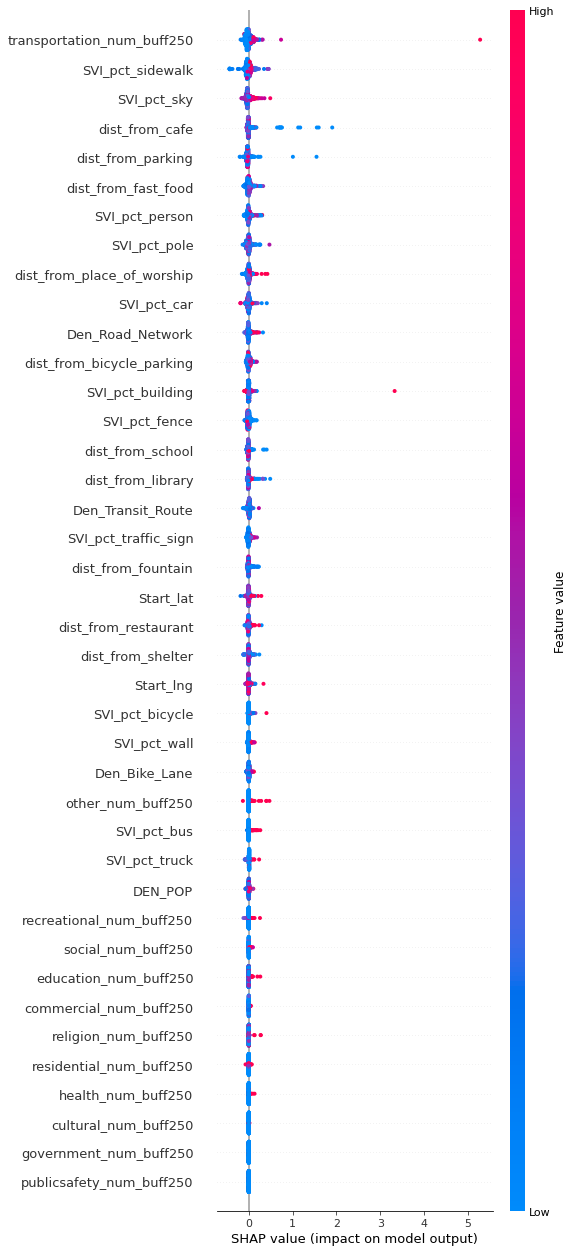

In [14]:
# Log Y
# Feature selection based on XGBoost

var_list = np.array(['Start_lat', 'Start_lng', 'DEN_POP',  'Den_Bike_Lane',
       'Den_Transit_Route', 'Den_Road_Network', 'other_num_buff250',
       'residential_num_buff250', 'education_num_buff250',
       'cultural_num_buff250', 'recreational_num_buff250',
       'social_num_buff250', 'transportation_num_buff250',
       'commercial_num_buff250', 'government_num_buff250',
       'religion_num_buff250', 'health_num_buff250',
       'publicsafety_num_buff250', 'dist_from_school',
      'dist_from_fast_food', 'dist_from_restaurant',
       'dist_from_parking', 'dist_from_cafe', 'dist_from_fountain', 
       'dist_from_library', 'dist_from_shelter', 'dist_from_place_of_worship',
       'dist_from_bicycle_parking', 'SVI_pct_sidewalk',
       'SVI_pct_building', 'SVI_pct_wall', 'SVI_pct_fence', 'SVI_pct_pole', 
       'SVI_pct_traffic_sign', 'SVI_pct_sky', 'SVI_pct_person', 
       'SVI_pct_car', 'SVI_pct_truck', 'SVI_pct_bus', 'SVI_pct_bicycle'])

y = regression_model_input_O_final['ridership']
X = regression_model_input_O_final[var_list]

xgb_model = XGBRegressor(random_state = 100)
xgb_model.fit(X, y)

# Predict on the test set
y_pred = xgb_model.predict(X)
print('MSE:', mean_squared_error(y, y_pred))
print('R2:', r2_score(y, y_pred))

# Initialize the SHAP explainer with the trained model
explainer = shap.Explainer(xgb_model, X)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X)

# Visualize SHAP values
shap.summary_plot(shap_values, X, max_display=X.shape[1])

##### LAT, LON, CENSUS 

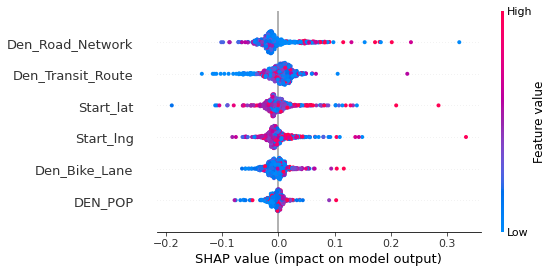

In [15]:
# Visualize SHAP values
shap.summary_plot(shap_values[:, 0:6], X.iloc[:, 0:6], max_display=X.shape[1])

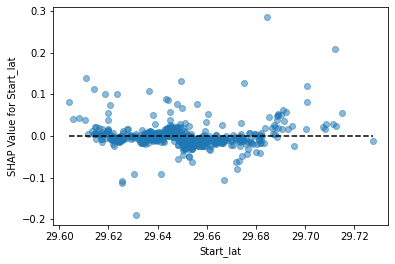

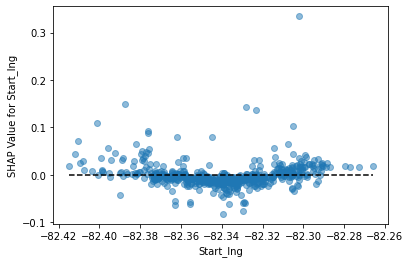

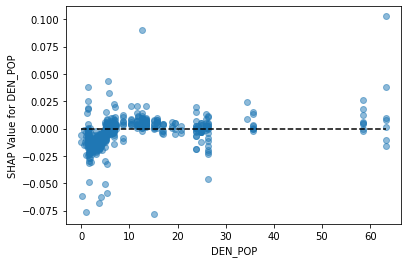

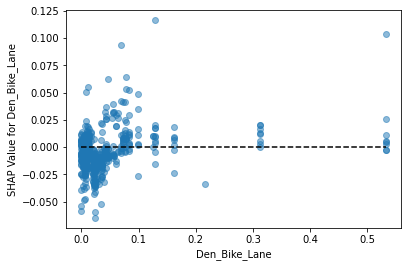

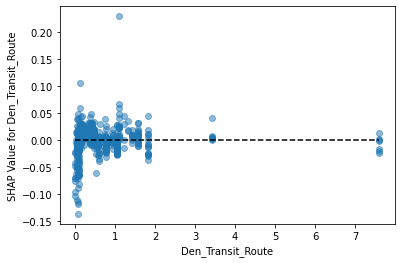

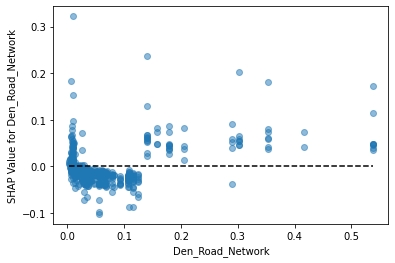

In [16]:
# Plot SHAP values of Feature 0 against the target
for i in range (6):
    feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
    plt.scatter(regression_model_input_O_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
    plt.plot(np.linspace(min(regression_model_input_O_final[feature_name]), max(regression_model_input_O_final[feature_name]), 100), np.zeros(100), 'k--')
    plt.xlabel(feature_name)
    plt.ylabel('SHAP Value for' + ' ' + feature_name)
    plt.show()

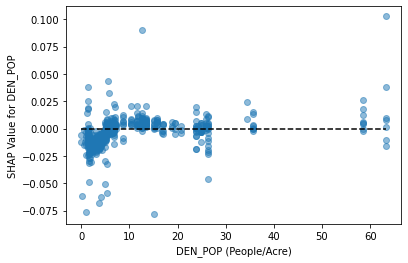

In [17]:
# Plot SHAP values of Feature 0 against the target
i = 2
feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
plt.scatter(regression_model_input_O_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
plt.plot(np.linspace(min(regression_model_input_O_final[feature_name]), max(regression_model_input_O_final[feature_name]), 100), np.zeros(100), 'k--')
plt.xlabel(feature_name + ' ' + '(People/Acre)')
plt.ylabel('SHAP Value for' + ' ' + feature_name)
plt.show()

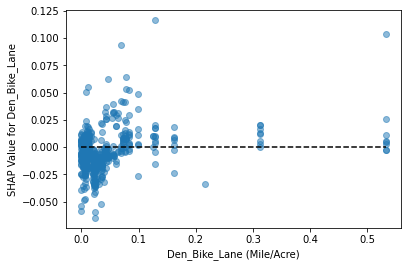

In [18]:
# Plot SHAP values of Feature 0 against the target
i = 3
feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
plt.scatter(regression_model_input_O_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
plt.plot(np.linspace(min(regression_model_input_O_final[feature_name]), max(regression_model_input_O_final[feature_name]), 100), np.zeros(100), 'k--')
plt.xlabel(feature_name + ' ' + '(Mile/Acre)')
plt.ylabel('SHAP Value for' + ' ' + feature_name)
plt.show()

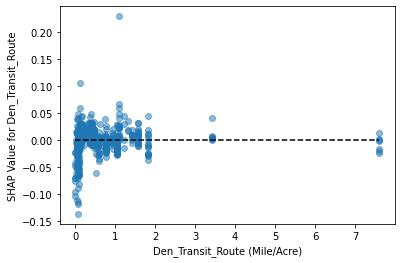

In [19]:
# Plot SHAP values of Feature 0 against the target
i = 4
feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
plt.scatter(regression_model_input_O_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
plt.plot(np.linspace(min(regression_model_input_O_final[feature_name]), max(regression_model_input_O_final[feature_name]), 100), np.zeros(100), 'k--')
plt.xlabel(feature_name + ' ' + '(Mile/Acre)')
plt.ylabel('SHAP Value for' + ' ' + feature_name)
plt.show()

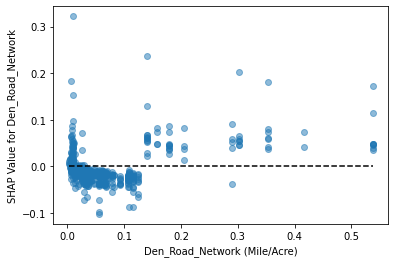

In [20]:
# Plot SHAP values of Feature 0 against the target
i = 5
feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
plt.scatter(regression_model_input_O_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
plt.plot(np.linspace(min(regression_model_input_O_final[feature_name]), max(regression_model_input_O_final[feature_name]), 100), np.zeros(100), 'k--')
plt.xlabel(feature_name + ' ' + '(Mile/Acre)')
plt.ylabel('SHAP Value for' + ' ' + feature_name)
plt.show()

### NUM POI

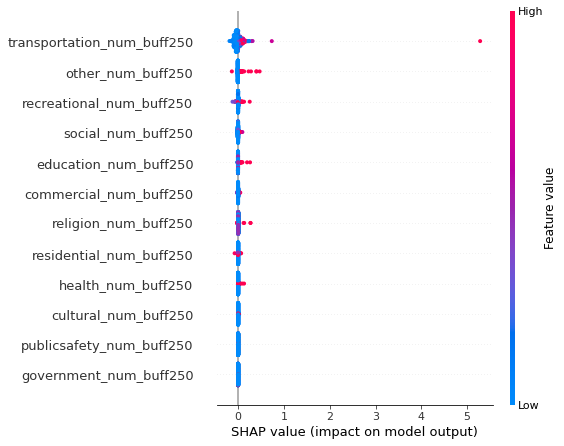

In [21]:
# Visualize SHAP values
shap.summary_plot(shap_values[:, 6:18], X.iloc[:, 6:18], max_display=X.shape[1])

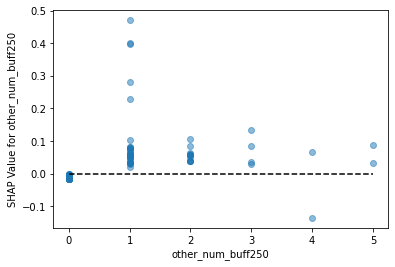

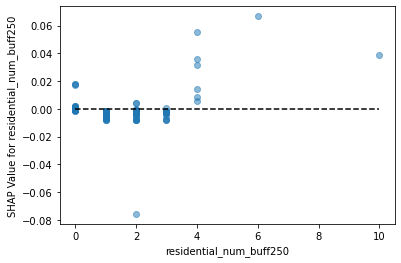

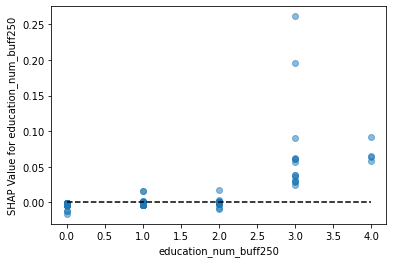

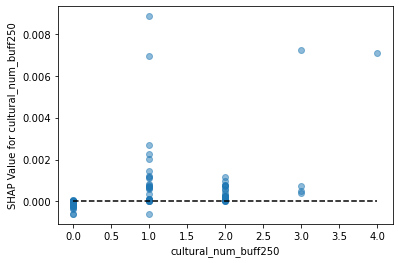

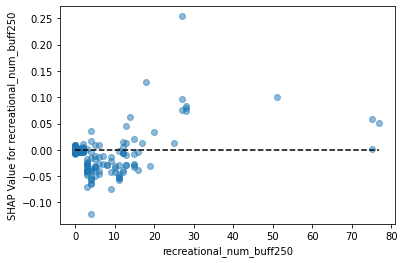

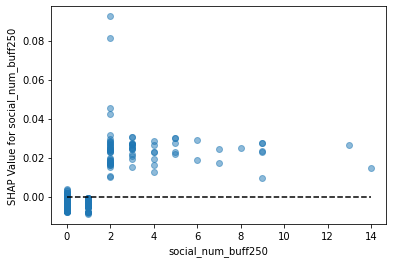

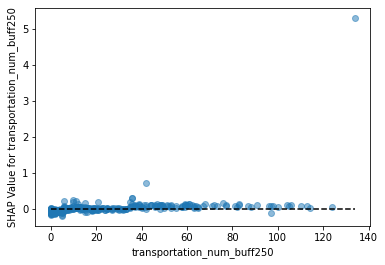

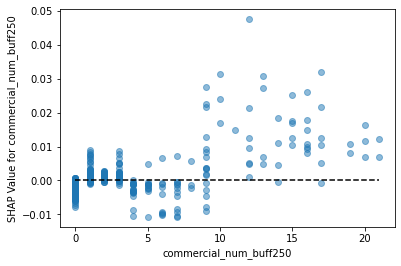

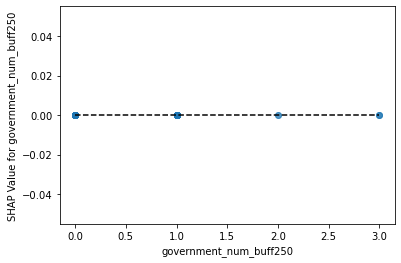

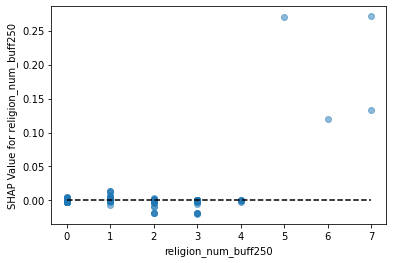

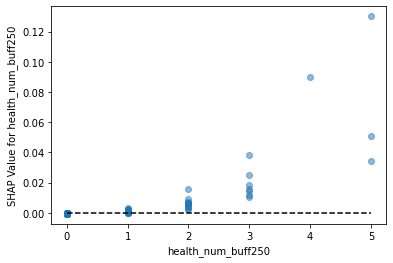

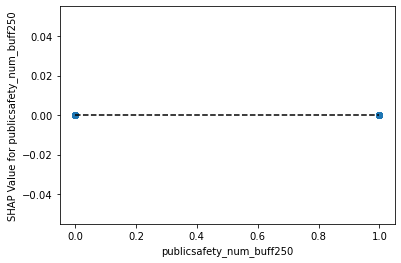

In [22]:
# Plot SHAP values of Feature 0 against the target
for i in range (6, 18):
    feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
    plt.scatter(regression_model_input_O_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
    plt.plot(np.linspace(min(regression_model_input_O_final[feature_name]), max(regression_model_input_O_final[feature_name]), 100), np.zeros(100), 'k--')
    plt.xlabel(feature_name)
    plt.ylabel('SHAP Value for' + ' ' + feature_name)
    plt.show()

### DIST POI

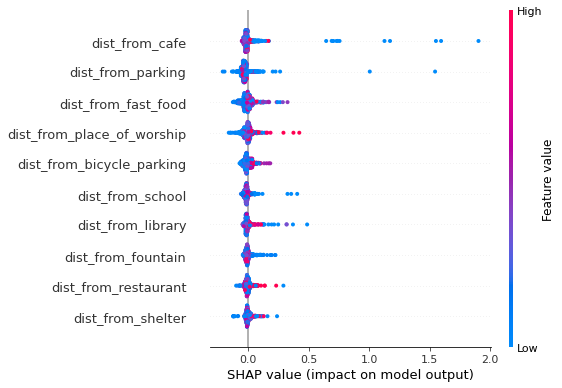

In [23]:
# Visualize SHAP values
shap.summary_plot(shap_values[:, 18:28], X.iloc[:, 18:28], max_display=X.shape[1])

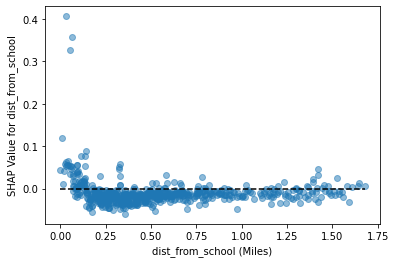

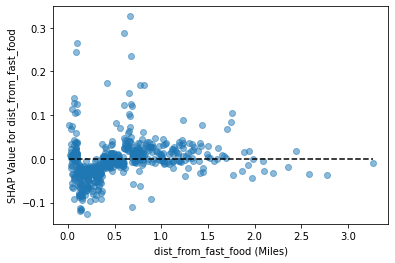

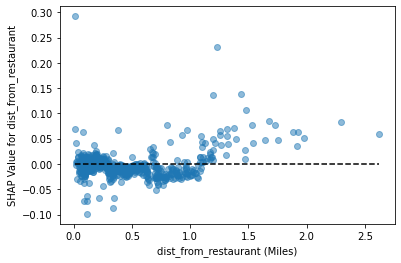

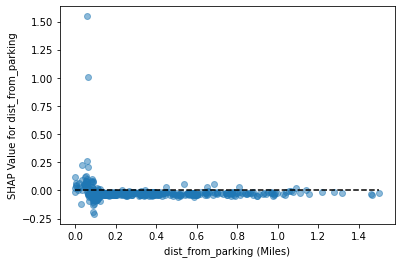

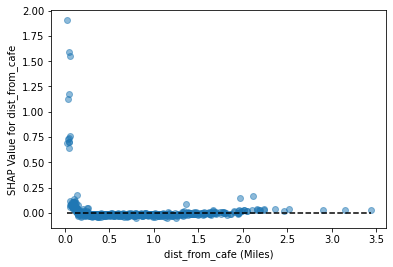

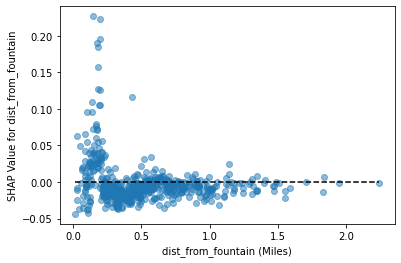

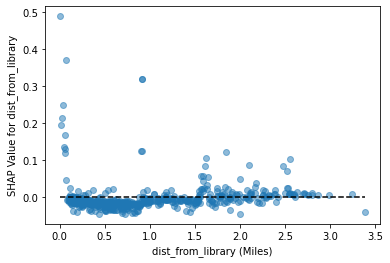

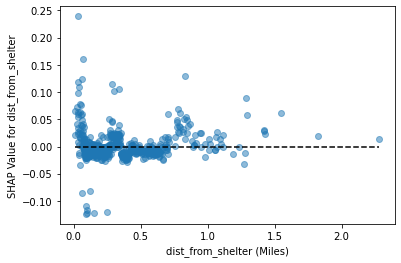

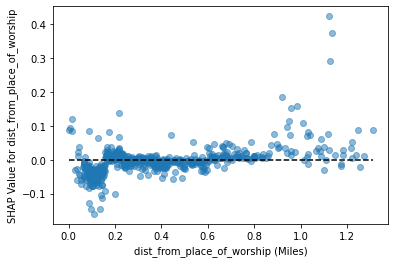

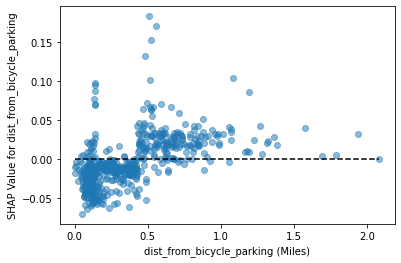

In [24]:
# Plot SHAP values of Feature 0 against the target
for i in range (18, 28):
    feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
    plt.scatter(regression_model_input_O_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
    plt.plot(np.linspace(min(regression_model_input_O_final[feature_name]), max(regression_model_input_O_final[feature_name]), 100), np.zeros(100), 'k--')
    plt.xlabel(feature_name + ' ' + '(Miles)')
    plt.ylabel('SHAP Value for' + ' ' + feature_name)
    plt.show()

##### SVI

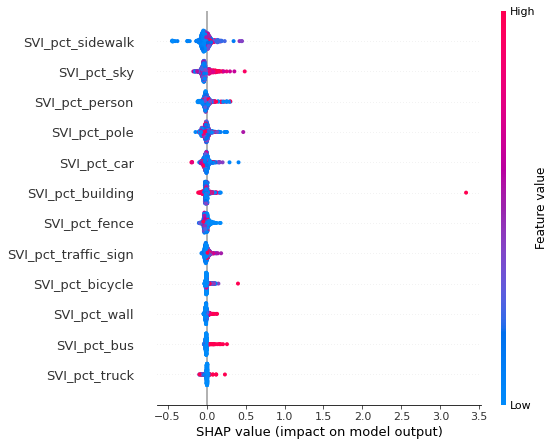

In [25]:
# Visualize SHAP values
shap.summary_plot(shap_values[:, 28:], X.iloc[:, 28:], max_display=X.shape[1])

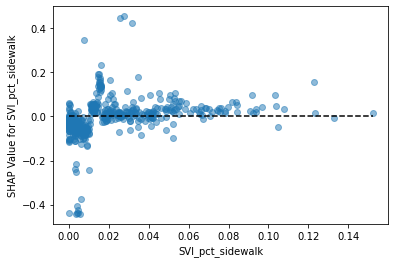

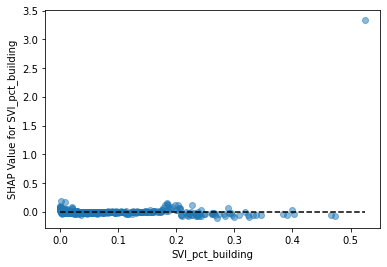

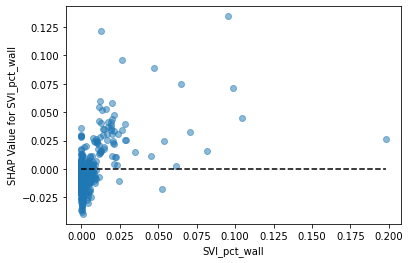

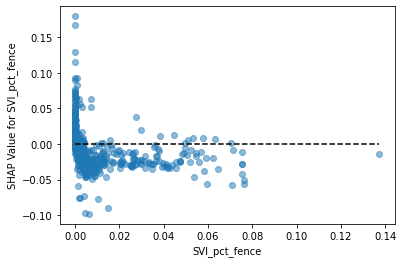

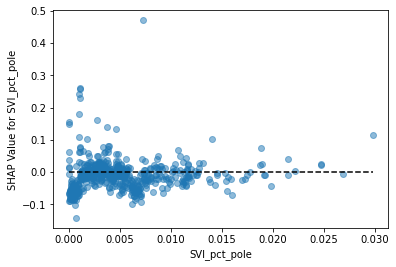

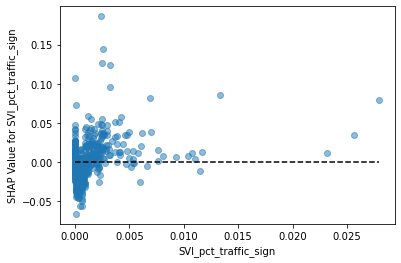

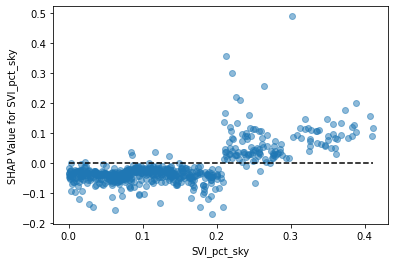

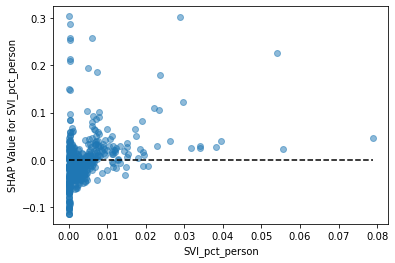

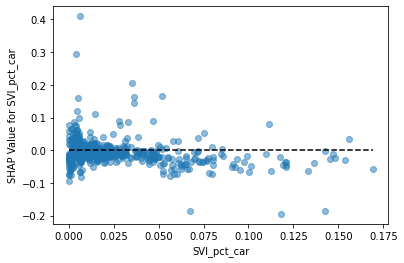

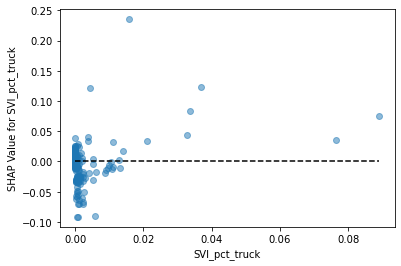

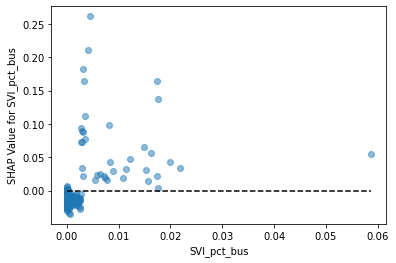

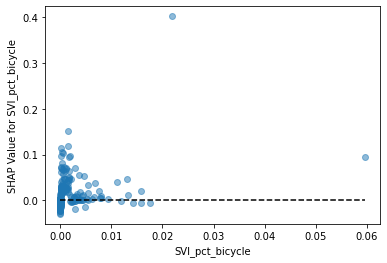

In [26]:
# Plot SHAP values of Feature 0 against the target
for i in range (28, len(var_list)):
    feature_name = var_list[i] # 'SVI_pct_sidewalk': 1, 
    plt.scatter(regression_model_input_O_final[feature_name], shap_values[:, np.where(var_list == feature_name)[0][0]], alpha=0.5)
    plt.plot(np.linspace(min(regression_model_input_O_final[feature_name]), max(regression_model_input_O_final[feature_name]), 100), np.zeros(100), 'k--')
    plt.xlabel(feature_name)
    plt.ylabel('SHAP Value for' + ' ' + feature_name)
    plt.show()